In [1]:
import os
import json
from collections import defaultdict
from argparse import ArgumentParser
from PIL import Image
import clip
import torch
import language_evaluation
import matplotlib.pyplot as plt
import numpy as np
import timm
import pathlib
from torchvision.transforms.functional import resize

from utils.adapter_decoder import Decoder, Config
from tokenizer import BPETokenizer
from p2_dataset import build_dataset
from utils.p2_model import ViL

myseed = 53  # set a random seed for reproducibility
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(myseed)
    torch.cuda.manual_seed_all(myseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
def readJSON(file_path):
    try:
        with open(file_path) as f:
            data = json.load(f)
        return data
    except:
        return None

def getGTCaptions(annotations):
    img_id_to_name = {}
    for img_info in annotations["images"]:
        img_name = img_info["file_name"].replace(".jpg", "")
        img_id_to_name[img_info["id"]] = img_name

    img_name_to_gts = defaultdict(list)
    for ann_info in annotations["annotations"]:
        img_id = ann_info["image_id"]
        img_name = img_id_to_name[img_id]
        img_name_to_gts[img_name].append(ann_info["caption"])
    return img_name_to_gts

In [3]:
predictions = readJSON("./p2_pred.json")
annotations = readJSON("./hw3_data/p2_data/val.json")
gts = getGTCaptions(annotations)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device = device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [5]:
# Check predictions content is correct
assert type(predictions) is dict
assert set(predictions.keys()) == set(gts.keys())
assert all([type(pred) is str for pred in predictions.values()])

In [6]:
min_clip = 1
min_name = None
max_clip = 0
max_name = None

for img_name, pred_caption in predictions.items():
    image_path = os.path.join("./hw3_data/p2_data/images/val", f"{img_name}.jpg")
    image = Image.open(image_path).convert("RGB")

    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([pred_caption]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_input)

    cos_sim = torch.nn.functional.cosine_similarity(image_features, text_features).item()
    clip_score = 2.5 * max(cos_sim, 0)

    if clip_score < min_clip:
        min_clip = clip_score
        min_name = img_name
    if clip_score > max_clip:
        max_clip = clip_score
        max_name = img_name

In [7]:
print(f"Min: {min_name}.jpg, {min_clip}")
print(f"Max: {max_name}.jpg, {max_clip}")

Min: 4859528111.jpg, 0.4132080078125
Max: 2554570943.jpg, 1.009521484375


In [8]:
decoder_weight_path = "./hw3_data/p2_data/decoder_model.bin"
encoder_model = timm.create_model("vit_large_patch14_clip_336.openai_ft_in12k_in1k", pretrained = True, num_classes = 0)
decoder_model = Decoder(Config(checkpoint = decoder_weight_path)) # decoder from TA

data_config = timm.data.resolve_model_data_config(encoder_model)
val_tfm = timm.data.create_transform(**data_config, is_training = False)

tokenizer = BPETokenizer(encoder_file = "./encoder.json", vocab_file = "./vocab.bpe")

In [9]:
min = Image.open(os.path.join("./hw3_data/p2_data/images/val", f"{min_name}.jpg")).convert("RGB")
min = val_tfm(min)
min = min.unsqueeze(0)

max = Image.open(os.path.join("./hw3_data/p2_data/images/val", f"{max_name}.jpg")).convert("RGB")
max = val_tfm(max)
max = max.unsqueeze(0)

In [10]:
def register_attention_hook(model, features):
    handle_decoder = None
    def hook_decoder(module, ins, outs):
        features.append(outs[1].detach().cpu())
    for i, block in enumerate(model.decoder.transformer.h):
        if i == 11:
            handle_decoder = block.multihead_attention.register_forward_hook(hook_decoder)
    return [handle_decoder]

def vis_atten_map(atten_mat, ids, image_fn, image_path):
    nrows = len(ids) // 5 if len(ids) % 5 == 0 else len(ids) // 5 + 1
    ncols = 5
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 8))
    feature_size = (24, 24)  # H/patch size, W/patch size = feature size
    for i, id in enumerate(ids):
        # print(atten_mat)
        attn_vector = atten_mat[:, i - 1, 1:]
        attn_map = torch.reshape(attn_vector, feature_size)
        attn_map -= torch.min(attn_map)
        attn_map /= torch.max(attn_map)
        # print(torch.min(attn_map), torch.max(attn_map))
        # print(attn_map.size())
        im = Image.open(image_path)
        size = im.size
        mask = resize(attn_map.unsqueeze(0), [size[1], size[0]]).squeeze(0)
        mask = np.uint8(mask * 255)
        # print(mask.shape)
        ax[i // 5][i % 5].imshow(im)
        if i == 0:
            ax[i // 5][i % 5].set_title('<|endoftext|>')
        else:
            ax[i // 5][i % 5].set_title(id)
            ax[i // 5][i % 5].imshow(mask, alpha=0.7, cmap='jet')
        ax[i // 5][i % 5].axis('off')
    for i in range(len(ids), nrows * ncols):
        ax[i // 5][i % 5].axis('off')
    plt.savefig((pathlib.Path("./p3_output") / image_fn))

In [11]:
model = ViL(encoder = encoder_model, decoder = decoder_model)
pth_path = "./p2_results/p2_adapter/p2_7_adapter_1.pth"
checkpoint = torch.load(pth_path, map_location = 'cpu')
print(sum([p.numel() for n, p in checkpoint.items()]))
model.load_state_dict(checkpoint, strict = False)
model.to(device)
model.eval()

34450944


ViL(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=40

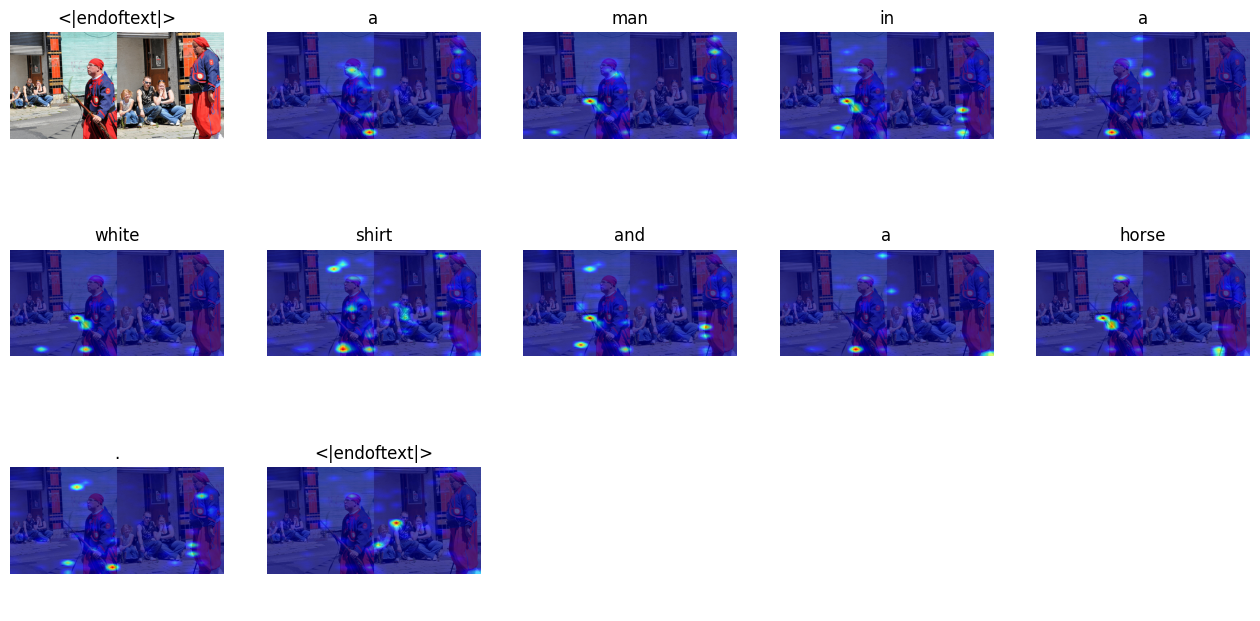

In [12]:
max_length = 96
features = []
caption = torch.zeros((1, max_length), dtype = torch.long) # set all zero
caption[:, 0] = 50256
output = []

for j in range(max_length - 1):
    min = min.to(device)
    caption = caption.to(device)
    to_rm_l = register_attention_hook(model, features)
    with torch.no_grad():
        predictions = model(min, caption)
    predictions = predictions[:, j, :]
    predicted_id = torch.argmax(predictions, axis = -1)

    # drop padding
    if predicted_id[0].item() == 50256:
        break
    if j == 71:
        break

    caption[:, j+1] = predicted_id[0]
    output.append(predicted_id[0].item())

result = tokenizer.decode(np.array(output))
result = "<|endoftext|> " + result + " <|endoftext|>"
result_list = result.split()
attention_matrix = features[-1]
vis_atten_map(attention_matrix, result_list, f"{min_name}.jpg", pathlib.Path(f"./hw3_data/p2_data/images/val/{min_name}.jpg"))

for handle in to_rm_l:
    handle.remove()

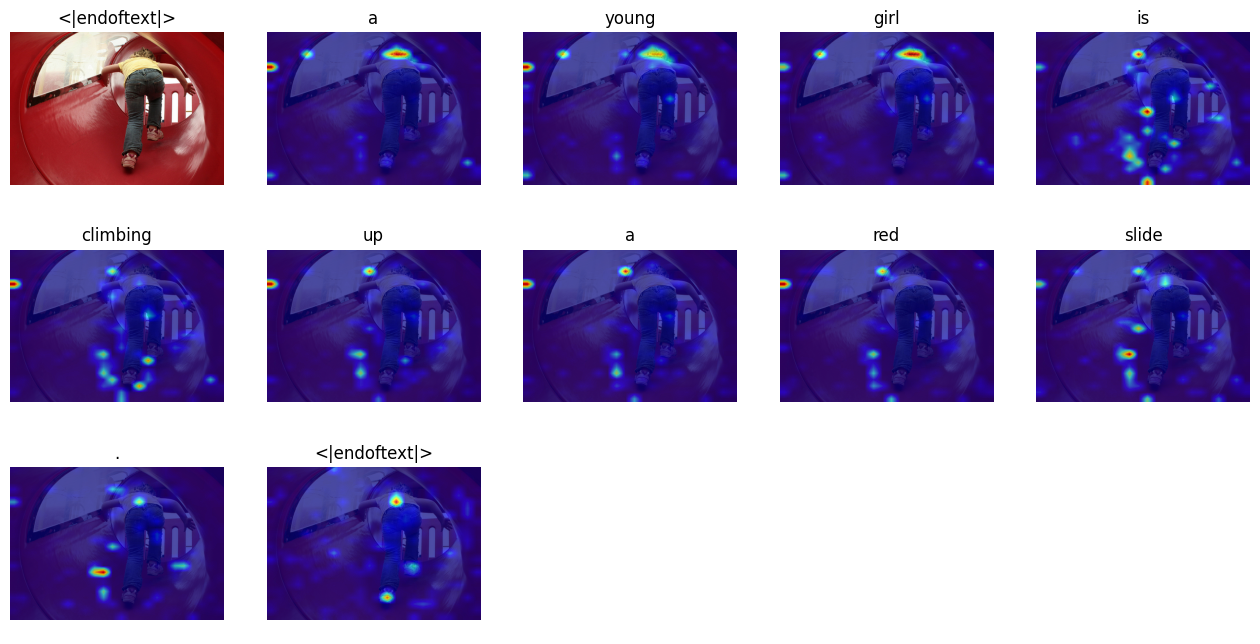

In [13]:
max_length = 96
features = []
caption = torch.zeros((1, max_length), dtype = torch.long) # set all zero
caption[:, 0] = 50256
output = []

for j in range(max_length - 1):
    max = max.to(device)
    caption = caption.to(device)
    to_rm_l = register_attention_hook(model, features)
    with torch.no_grad():
        predictions = model(max, caption)
    predictions = predictions[:, j, :]
    predicted_id = torch.argmax(predictions, axis = -1)

    # drop padding
    if predicted_id[0].item() == 50256:
        break
    if j == 71:
        break

    caption[:, j+1] = predicted_id[0]
    output.append(predicted_id[0].item())

result = tokenizer.decode(np.array(output))
result = "<|endoftext|> " + result + " <|endoftext|>"
result_list = result.split()
attention_matrix = features[-1]
vis_atten_map(attention_matrix, result_list, f"{max_name}.jpg", pathlib.Path(f"./hw3_data/p2_data/images/val/{max_name}.jpg"))

for handle in to_rm_l:
    handle.remove()